<a href="https://colab.research.google.com/github/tccoleman26/zartico_things/blob/main/Count_Unique_Visitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counting Unique Visitors in a Spatio-Temporal Frame

This notebook is to describe how to get an estimate of a population in an area with only using a sample of trajectory and demographic data.

This notebook is setup as the following, we first randomnly generate users that are in downtown Jackson Wyoming. We then attempt to classify the tourists away from the workers in Downtown Jackson since those are considered visitors. And then finally we go into the detail into how to estimate the population using the Schnabel method.

In [ ]:
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install scikit-mobility

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   388k      0  0:00:01  0:00:01 --:--:--  388k
checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether ln -s works... yes
checking whether make sets $(MAKE)... yes
checking host system type... x86_64-unknown-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether we are using the GNU C compil

In [ ]:
import pandas as pd
import numpy as np
import skmob
import math


from random import gauss, choice, choices, randint, randrange
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
import uuid

from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split


In [ ]:
class GenerateUser:
    """Generate Users for GeoSpatial population estimatation."""

    def __init__(self, 
                 bounding_box:Polygon, 
                 start_date = datetime.today(),
                 end_date = datetime.today() + timedelta(days=8),
                 timestep: timedelta=timedelta(seconds=4)):
        
        """
        Constructors

        Args:
            bounding_box (Shapely.Polygon): The bounding box that the entitity is in.
            ndays (int): The number of days that we are simulating
            timestep: the step between seconds

        Please note, this does not incorporate sleep/awake time cycles and this is not production level code.
        """

        self.start_date = start_date
        self.end_date = end_date
        self.timestep = timestep

        self.id = str(uuid.uuid1().int)

        self.bounding_box = bounding_box
        coords = list(self.bounding_box.centroid.coords[0])
        bounds = self.bounding_box.bounds
        min_lon, min_lat, max_lon, max_lat = bounds[0], bounds[1],bounds[2], bounds[3]

        self.start_lat  = coords[1] + gauss(0, 0.1*(abs(max_lat-min_lat)))        
        self.start_lon  = coords[0] + gauss(0, 0.1*(abs(max_lon-min_lon)))        
        self.start_point = Point(self.start_lon, self.start_lat)


        self.trajectory_length = self._dt_generator()

        self.income = self.generate_income()
        self.interest = self.generate_interests()
        self.type_of_person = self.generate_local_or_tourist()[0]
        self.distance_from_home = self.generate_distance_from_home()
 
    def _dt_generator(self):
        """
        Generates the datetime column

        """
        dt_list = []
        sd = self.start_date
        while sd <= self.end_date:
            dt_list.append(sd)
            sd += self.timestep
        return dt_list

    def generate_user_trajectory(self):
        """
        Generate use Trajectory in Points based on previous point

        Returns: 
            List
        """
        lon_list = [self.start_lon]
        lat_list = [self.start_lat]
        pt_list = [self.start_point]

        for i in range(1, len(self.trajectory_length)-1):

            lon, lat = pt_list[i-1].coords[0][0], pt_list[i-1].coords[0][1]
            next_lon = lon + gauss(0, 0.000002)
            next_lat = lat + gauss(0, 0.000002)
            next_point = Point(next_lon, next_lat)

            if next_point.within(self.bounding_box):
                pt_list.append(next_point)
                lon_list.append(next_lon)
                lat_list.append(next_lat)

            else:
                pt_list.append(Point(lon, lat))
                lon_list.append(lon)
                lat_list.append(lat)

        return pt_list, lon_list, lat_list

    def generate_income(self):
        """
        Generate Random Income
        
        Return:
            Int
        """
        income_options = [50000, 40000, 60000, 110000, 130000, 250000, 400000, 500000]
        return choice(income_options)

    def generate_interests(self):
        """
        Generate random interests

        Returns:
            String
        """

        interests = ['barely_making_it', 'dumpster diving', 'skiing', 'yachting',
                     'traveling', 'shopping', 'not drowing in debt']
        if self.income > 110000:
            weights  = (.1, .02, .2, .3, .6, .4, .9)
        
        else:
            weights = (0.9, 0.8, 0.4, 0.3, 0.1, 0.1,0.05)
        
        return choices(interests, weights= weights, k=1)[0]

    def generate_distance_from_home(self):
        """
        Get the Euclidean distance to a persons home.

        

        """
        if self.income > 110000:
            home_lat = self.start_lat + gauss(0, 2)
            home_lon = self.start_lon + gauss(0, 2)
            
        else:
            home_lat = self.start_lat + gauss(0, 0.1)
            home_lon = self.start_lon + gauss(0, 0.1) 

        home = np.array([home_lat,home_lon])
        location =np.array([self.start_lat, self.start_lon])

        return np.linalg.norm(home - location)*110

        
    def generate_local_or_tourist(self):
        """

        """
        options = ['tourist','local'] # I thought about calling this THE HELP
        if self.income > 110000:
            weights = (0.9, 0.1)
        else:
            weights = (0.1, 0.9)

        return choices(options, weights=weights)

    def get_df(self):
        """
        Get Normalized Pandas DataFrame with trajectory and Demographic Data. 

        """
        number_of_points = len(self.trajectory_length)-1
        ts_list = [i*self.timestep.total_seconds() for i in range(number_of_points)]
        id = [self.id for  _ in range(number_of_points)]
        interests = [self.interest for _ in range(number_of_points)]
        type_of_person = [self.type_of_person for _ in range(number_of_points)]
        distance_from_home = [self.distance_from_home for _ in range(number_of_points)]
        income = [self.income for _ in range(number_of_points)]
        point_trajectory, lon_list, lat_list = self.generate_user_trajectory()

        df = pd.DataFrame({
                    'id':id, 
                    'timestep (s)': ts_list, 
                    'datetime':self.trajectory_length[:-1], 
                    "geometry":point_trajectory,
                    'lat': lat_list,
                    'lon':lon_list,
                    'income':income,
                    'distance_from_home (km)':distance_from_home,
                    'interests': interests, 
                    'target':type_of_person
                    }
                    )
        
        rand_start = randint(0, int(number_of_points/2))
        rand_end = randint(int(number_of_points/2), number_of_points)
        
        option = randrange(2)
        if option == 0:
            df = df.iloc[rand_start:rand_end, :].reset_index(drop=True)
            df['timestep (s)'] = [i*self.timestep.total_seconds() for i in range(len(df))]

        if option == 1:
                df_1 = df.iloc[:rand_start, :]
                df_1['timestep (s)'] = [i*self.timestep.total_seconds() for i in range(len(df_1))]

                df_2 = df.iloc[rand_end:, : ]
                df_2['timestep (s)'] = [i*self.timestep.total_seconds() for i in range(len(df_2))]
                df = pd.concat([df_1,df_2], ignore_index=True)

        return df

# Generating Users

To begin, we are going to to be generating approximately 20 users in a relatively small and confined space that is downtown Jackson Wyoming. These users are only going to a small sample of what is around. We are also going to simulate some of the data that is found in the Near Dataset.

## Data Availability:
The NEAR Dataset has two parts that are relevant to us, Carbon and Vista, and to my knowledge this data can be merged together on our end using device id's. 

- Basic Path Data (Vista)
- Demographic Data (Vista)
- Age Range (Vista)
- Income Data (Vista)
- Ethnicity (Vista)
- Place Matrix (Carbon)
- Spending Patterns (Carbon)
- Brand Preferences (Carbon)
- Home Locations (Carbon)


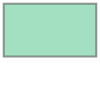

In [ ]:
outer_bounding_box = Polygon([[-110.769538, 43.484552],
                             [-110.769538, 43.474852],
                             [-110.752538,43.474852],
                             [-110.752538,43.484552],
                            [-110.769538, 43.484552]])
outer_bounding_box

In [ ]:
start_date = datetime(2022,4,22, 10)
end_date = datetime (2022,4,22,18)

pdf = pd.concat([GenerateUser(outer_bounding_box, 
                              start_date=start_date, 
                              end_date=end_date,
                              timestep=timedelta(seconds=3)).get_df() 
                              for _ in range(100)],ignore_index=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## All Users Trajectory in Jackson

In [ ]:
tdf = skmob.TrajDataFrame(pdf, latitude='lat', longitude='lon', user_id='id', datetime='datetime')
tdf.plot_trajectory(max_points=10000)

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  start_end_markers=start_end_markers, control_scale=control_scale)
/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  start_end_markers=start_end_markers, control_scale=control_scale)


## Number of Tourists vs Locals

In [ ]:

demo_df = pdf.iloc[:, 6:].drop_duplicates()
print("Number of Tourists " +str(len(demo_df.loc[demo_df['target']=='tourist'])))
print("Number of Locals " +str(len(demo_df.loc[demo_df['target']=='local'])))


Number of Tourists 48
Number of Locals 52


### Classification


Binary Classification of Locals vs Visitors using the data listed above. Then with the labeled data, count distinct points in polygon in a given timeframe. Then estimate unique vistors using statistics. By using classification we can then find how many people are truly unique by their attributes. If using purely demographics does not work, we then have to look into some deep learning options. 



In [ ]:
feature_df = pdf[['income','distance_from_home (km)','interests','target']].drop_duplicates().reset_index(drop=True)
target = feature_df[['target']].dropna(how='any')
input = feature_df[['income','distance_from_home (km)','interests']]

enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(input[['interests']]).toarray())
enc_df.columns = enc.categories_
feature_df = enc_df.join(input)
feature_df.drop('interests',axis=1,inplace=True)
feature_df.drop_duplicates(inplace=True)
feature_df.reset_index(drop=True, inplace=True)
feature_df.dropna(how='any',inplace=True)
feature_df

,"(barely_making_it,)","(dumpster diving,)","(not drowing in debt,)","(shopping,)","(skiing,)","(traveling,)","(yachting,)",income,distance_from_home (km)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,250000,207.055591
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,130000,119.432063
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,110000,10.119886
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000,15.903496
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50000,8.259696
...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,130000,318.940526
96,0.0,1.0,0.0,0.0,0.0,0.0,0.0,60000,12.274071
97,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40000,9.526484
98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,130000,161.257065


In [ ]:
y = LabelEncoder().fit_transform(target['target'])
X = feature_df.to_numpy()
y = LabelEncoder().fit_transform(target['target'])

print(X.shape, y.shape)

(100, 9) (100,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 9) (30, 9) (70,) (30,)


In [ ]:
clf = RandomForestClassifier(n_estimators=100)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
yhat = clf.predict(X_test)
print(accuracy_score(y_test, yhat))

0.8333333333333334


## Confusion Matrix

Tons of False Positives, and false negatives

In [ ]:
confusion_matrix(y_test, yhat)

array([[12,  3],
       [ 2, 13]])

In [ ]:
print(f1_score(y_test, yhat))

0.8387096774193549


In [ ]:
y = clf.predict(X)

X_df = pd.DataFrame(X)
y_df = pd.DataFrame({'target':y})

labeled_df = pd.concat([X_df, y_df],axis=1)
columns = [col[0] for col in feature_df.columns]


## Tourists Plots

Let's take a look at the demographics that we are intersted in counting. Since the F1 Score is very high, it should be suitable to just use the original dataframe.

In [ ]:
tdf = skmob.TrajDataFrame(pdf.loc[pdf['target']=='tourist'], latitude='lat', longitude='lon', user_id='id', datetime='datetime')
tdf.plot_trajectory(max_points=10000)

/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  start_end_markers=start_end_markers, control_scale=control_scale)
/usr/local/lib/python3.7/dist-packages/skmob/core/trajectorydataframe.py:571: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  start_end_markers=start_end_markers, control_scale=control_scale)


## Estimating the Unique Visitor in a specific time and place.

To do this, we will need to define another polygon, and then we will be using the Schnabel method of estimation the unique visitor population.

The Schnabel method, most commonly used in Biology and Ecology, is used to estimate the population of the animals in the wild by marking those that have been previously marked at time.  


**Schnabel Method Equation**

$population_{visitors}=\frac{∑_{i=1}^{n}M_{i}C_{i}}{∑_{i}^{n}R_{i}}$

**Parameters**: 
- $M_{i}$ = Previously measured entities in a population study. 
- $C_{i}$ = Population found at time $i$.
- $R_{i}$ = Number of marked entities at $t_{i-1}$ and $t_{i}$ 


## Capture Area

The area we are looking to count the unique visitations inside the area. This area is approximately half the area of the unique visitor area. To find the unique entities, we need to first find define a time range as well as a polygon to find users in. The dates to be used in this example is going to be. 

In [ ]:
capture_area  = Polygon([
                        [-110.765288, 43.482127],
                        [-110.765288, 43.477277],
                        [-110.756788, 43.477277],
                        [-110.756788, 43.482127]
                        ]
                        )
print(start_date, end_date)

2022-04-22 10:00:00 2022-04-22 18:00:00


## Data Preperation

When counting unique visitors covered in the capture area, we need to first define the time range that is in a Pandas DataFrame. That will be our baseline time series. 


After we have done that, we then "pretend" that once an entity enters in the polygo they never leave. This ensures that we mark the caught entities at every timestamp, and they remain unique. Entities that have not yet entered into the polygon are coded as 0. Then the entities that have then entered the polygon are coded as 1 for the rest of the DataFrame.



In [ ]:
baseline_ts = pd.DataFrame(pd.date_range(start_date, end_date-timedelta(seconds=3), freq='3S'))
baseline_ts.columns = ['datetime']

In [ ]:
df_list = []
id_list = pdf['id'].drop_duplicates().tolist()

for id in id_list:
    trajectory_df = pdf.loc[pdf['id'] == id][['geometry','datetime']].set_index('datetime')
    trajectory_df.columns = ["geometry_id_" +id]
    geom_column  = trajectory_df.columns[0]
    trajectory_df = (trajectory_df[geom_column].apply(capture_area.contains)).to_frame()

    if len(trajectory_df) >=1:
        trajectory_df[geom_column] = 1
        trajectory_df = trajectory_df.merge(baseline_ts, on='datetime', how='right').ffill().fillna(0)
        df_list.append(trajectory_df)


obs_df = pd.concat(df_list,axis=1).dropna(axis=1, how='all').ffill(axis=1)
obs_df = obs_df.loc[:,~obs_df.columns.duplicated()]
obs_df.set_index("datetime",inplace=True)

## Schnabel Method for an Estimation of Abundance

The Schnabel method estimates the population over time (minimum of three timestamps). And since we have set up the data to only have unique entities we can now run the equation $population_{visitors}=\frac{∑_{i=1}^{n}M_{i}C_{i}}{∑_{i}^{n}R_{i}}$


In [ ]:
recaptured_df = pd.DataFrame(obs_df[obs_df.shift(-1) == 1].sum(axis=1), columns=['R'])
uncaptured_df= pd.DataFrame((obs_df[obs_df.shift(-1) == 0 | obs_df.shift(1).isnull()]).sum(axis=1), columns=['U'])
captured_df = pd.DataFrame(recaptured_df['R'] + uncaptured_df['U'], columns=['C'])
schnabel_df = pd.concat([captured_df,uncaptured_df, recaptured_df], axis=1)
schnabel_df['M'] = schnabel_df['U'].cumsum()
schnabel_df['CM'] = schnabel_df['M']*schnabel_df['C']
schnabel_df

,C,U,R,M,CM
datetime,,,,,
2022-04-22 10:00:00,104.0,52.0,52.0,52.0,5408.0
2022-04-22 10:00:03,52.0,0.0,52.0,52.0,2704.0
2022-04-22 10:00:06,52.0,0.0,52.0,52.0,2704.0
2022-04-22 10:00:09,52.0,0.0,52.0,52.0,2704.0
2022-04-22 10:00:12,52.0,0.0,52.0,52.0,2704.0
...,...,...,...,...,...
2022-04-22 17:59:45,100.0,0.0,100.0,52.0,5200.0
2022-04-22 17:59:48,100.0,0.0,100.0,52.0,5200.0
2022-04-22 17:59:51,100.0,0.0,100.0,52.0,5200.0


## Final Estimate of Visitors

This is how you can get a estimate of a population in that enters in a polygon and never leaves.

In [ ]:
visitor_pop_estimate = (np.sum(schnabel_df['CM'])/np.sum(schnabel_df['R']))
print(r"Population Estimate is {0} people +/- ({1}) at a 95% Confidence Interval".format(int(visitor_pop_estimate),1.96*np.sqrt(visitor_pop_estimate/len(id_list))))

Population Estimate is 52 people +/- (1.4134190849679382) at a 95% Confidence Interval
